In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from mplsoccer import Pitch


In [7]:
df = pd.read_csv('events.csv',sep = ';')
df.head()

,id,eventId,typeId,periodId,timeMin,timeSec,team_name,outcome,x,y,...,shortName,shorter name,pro,x1_bin_xT,y1_bin_xT,x2_bin_xT,y2_bin_xT,start_zone_value_xT,end_zone_value_xT,xT
0,2847225799,3,Pass,1,0,0,27xvwccz8kpmqsefjv2b2sc0o,Successful,60.12,39.92,...,P. Aubameyang,PA,-3.026862,6.0,3.0,5.0,4.0,0.016895,0.014846,-0.002049
1,2847225857,4,Pass,1,0,2,27xvwccz8kpmqsefjv2b2sc0o,Successful,53.64,38.00,...,M. O'Riley,MO,-14.890577,5.0,3.0,3.0,2.0,0.014846,0.011105,-0.003741
2,2847225935,5,Pass,1,0,6,27xvwccz8kpmqsefjv2b2sc0o,Successful,42.24,23.92,...,B. Pavard,BP,-2.952130,4.0,2.0,3.0,5.0,0.012692,0.011105,-0.001587
3,2847225955,6,Pass,1,0,10,27xvwccz8kpmqsefjv2b2sc0o,Successful,35.76,50.40,...,F. Medina,FM,-11.840750,3.0,5.0,2.0,3.0,0.011105,0.010165,-0.000939
4,2847225969,7,Pass,1,0,12,27xvwccz8kpmqsefjv2b2sc0o,Successful,23.40,36.80,...,L. Balerdi,LB,4.364951,2.0,3.0,3.0,1.0,0.010165,0.010595,0.000429


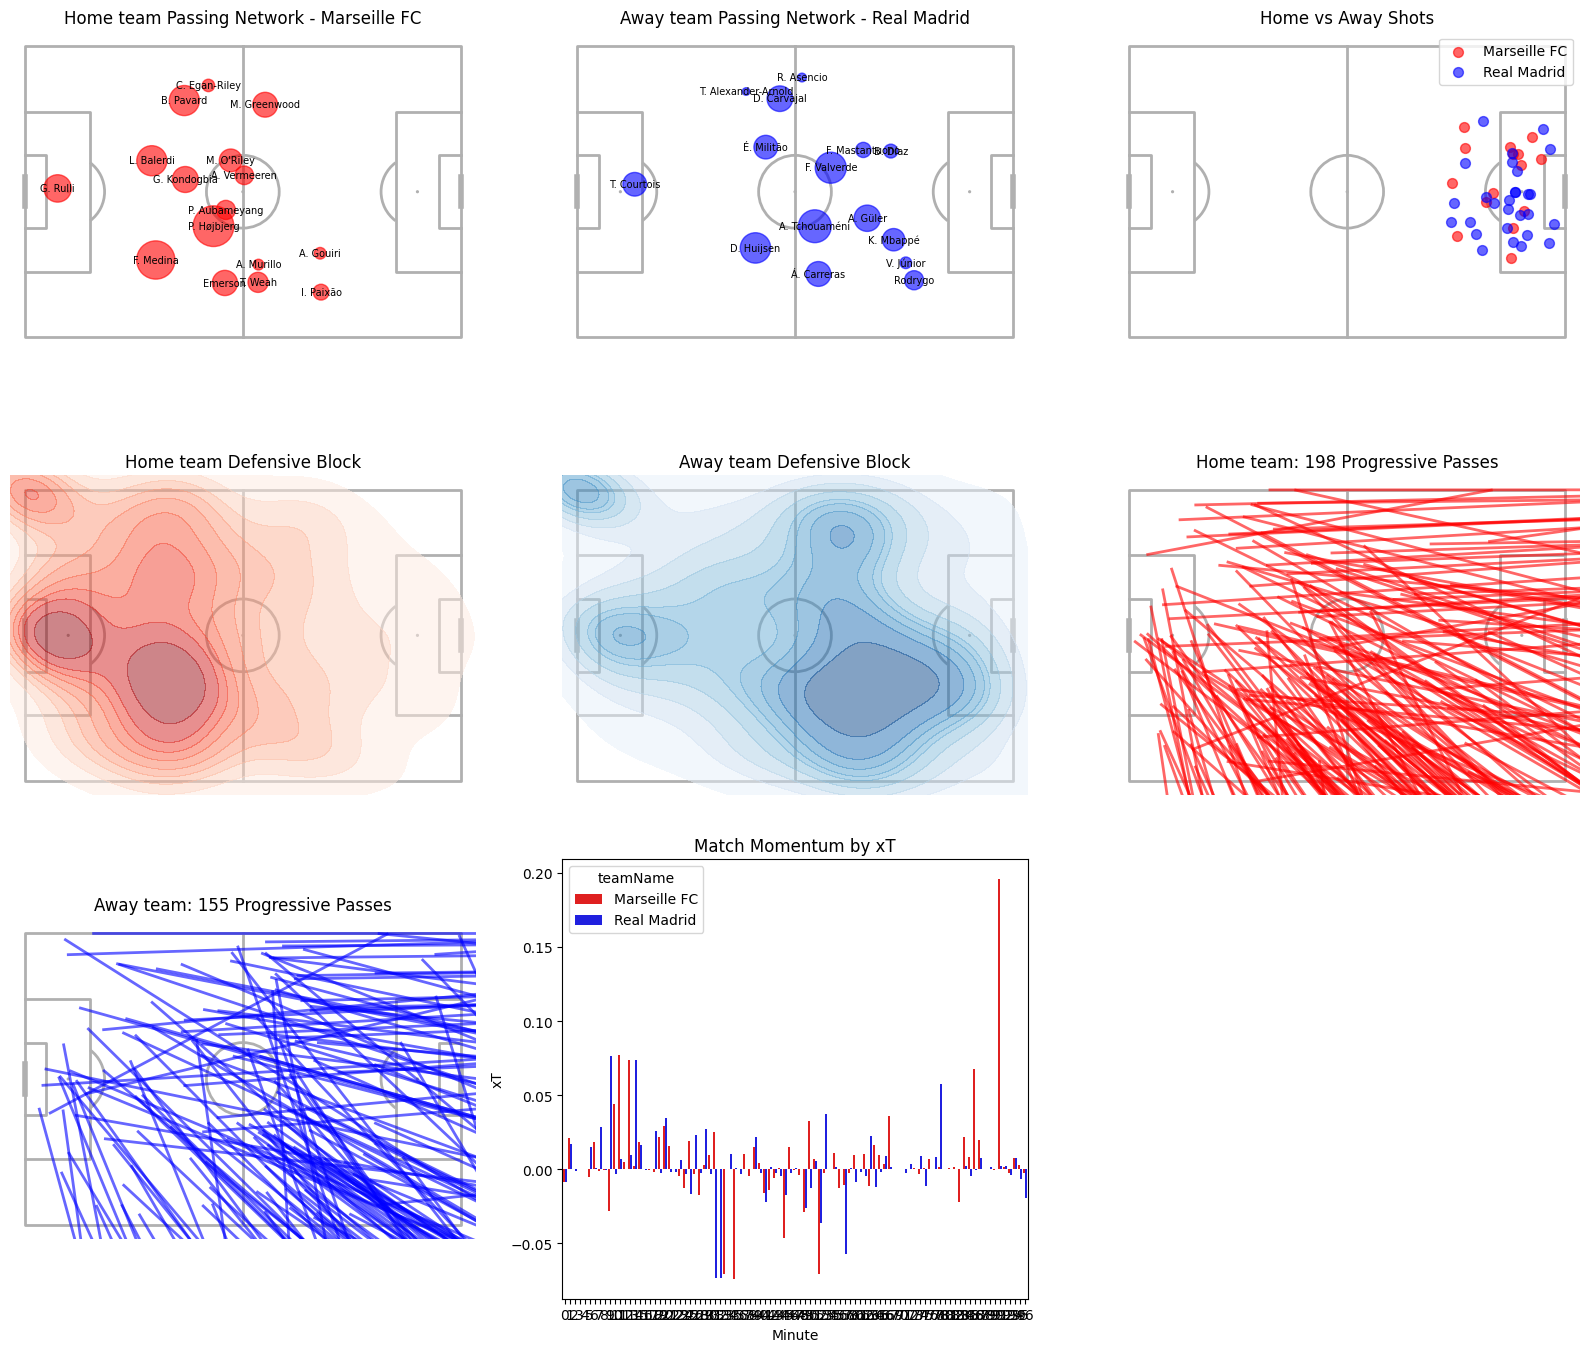

In [ ]:

team_map = {
    "27xvwccz8kpmqsefjv2b2sc0o": "Marseille FC",
    "3kq9cckrnlogidldtdie2fkbl": "Real Madrid"
}
df['teamName'] = df['team_name'].map(team_map)


home_df = df[df['teamName'] == 'Marseille FC']
away_df = df[df['teamName'] == 'Real Madrid']


fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

pitch = Pitch(pitch_type='statsbomb')


home_passes = home_df[home_df['typeId'] == 'Pass']
home_passes = home_passes.groupby(['shortName']).agg({'x': 'mean', 'y': 'mean', 'xT': 'count'}).reset_index()

pitch.draw(ax=axes[0])
axes[0].set_title("Home team Passing Network - Marseille FC", fontsize=12)
pitch.scatter(home_passes.x, home_passes.y, s=home_passes.xT * 10, color='red', alpha=0.6, ax=axes[0])
for _, row in home_passes.iterrows():
    axes[0].text(row.x, row.y, row['shortName'], ha='center', va='center', fontsize=7)


away_passes = away_df[away_df['typeId'] == 'Pass']
away_passes = away_passes.groupby(['shortName']).agg({'x': 'mean', 'y': 'mean', 'xT': 'count'}).reset_index()

pitch.draw(ax=axes[1])
axes[1].set_title("Away team Passing Network - Real Madrid", fontsize=12)
pitch.scatter(away_passes.x, away_passes.y, s=away_passes.xT * 10, color='blue', alpha=0.6, ax=axes[1])
for _, row in away_passes.iterrows():
    axes[1].text(row.x, row.y, row['shortName'], ha='center', va='center', fontsize=7)


shot_types = ['Goal', 'Miss', 'Attempt Saved', 'Post']
home_shots = home_df[home_df['typeId'].isin(shot_types)]
away_shots = away_df[away_df['typeId'].isin(shot_types)]

pitch.draw(ax=axes[2])
axes[2].set_title("Home vs Away Shots", fontsize=12)
pitch.scatter(home_shots.x, home_shots.y, color='red', s=50, alpha=0.6, label='Marseille FC', ax=axes[2])
pitch.scatter(away_shots.x, away_shots.y, color='blue', s=50, alpha=0.6, label='Real Madrid', ax=axes[2])
axes[2].legend(loc='upper right')


pitch.draw(ax=axes[3])
sns.kdeplot(x=home_df.x, y=home_df.y, fill=True, cmap='Reds', alpha=0.5, ax=axes[3])
axes[3].set_title("Home team Defensive Block", fontsize=12)


pitch.draw(ax=axes[4])
sns.kdeplot(x=away_df.x, y=away_df.y, fill=True, cmap='Blues', alpha=0.5, ax=axes[4])
axes[4].set_title("Away team Defensive Block", fontsize=12)


def get_progressive_passes(df):
    prog = df[(df['typeId'] == 'Pass') & (df['x2_bin_xT'] - df['x1_bin_xT'] > 0.2)]
    return prog

home_prog = get_progressive_passes(home_df)
away_prog = get_progressive_passes(away_df)

pitch.draw(ax=axes[5])
pitch.lines(home_prog.x, home_prog.y, home_prog.x2_bin_xT * 100, home_prog.y2_bin_xT * 100,
            lw=2, color='red', alpha=0.6, ax=axes[5])
axes[5].set_title(f"Home team: {len(home_prog)} Progressive Passes", fontsize=12)

pitch.draw(ax=axes[6])
pitch.lines(away_prog.x, away_prog.y, away_prog.x2_bin_xT * 100, away_prog.y2_bin_xT * 100,
            lw=2, color='blue', alpha=0.6, ax=axes[6])
axes[6].set_title(f"Away team: {len(away_prog)} Progressive Passes", fontsize=12)


momentum = df.groupby(['timeMin', 'teamName'])['xT'].sum().reset_index()
sns.barplot(data=momentum, x='timeMin', y='xT', hue='teamName', palette=['red', 'blue'], ax=axes[7])
axes[7].set_title("Match Momentum by xT", fontsize=12)
axes[7].set_xlabel("Minute")
axes[7].set_ylabel("xT")

axes[8].axis('off')

plt.tight_layout()
plt.show()


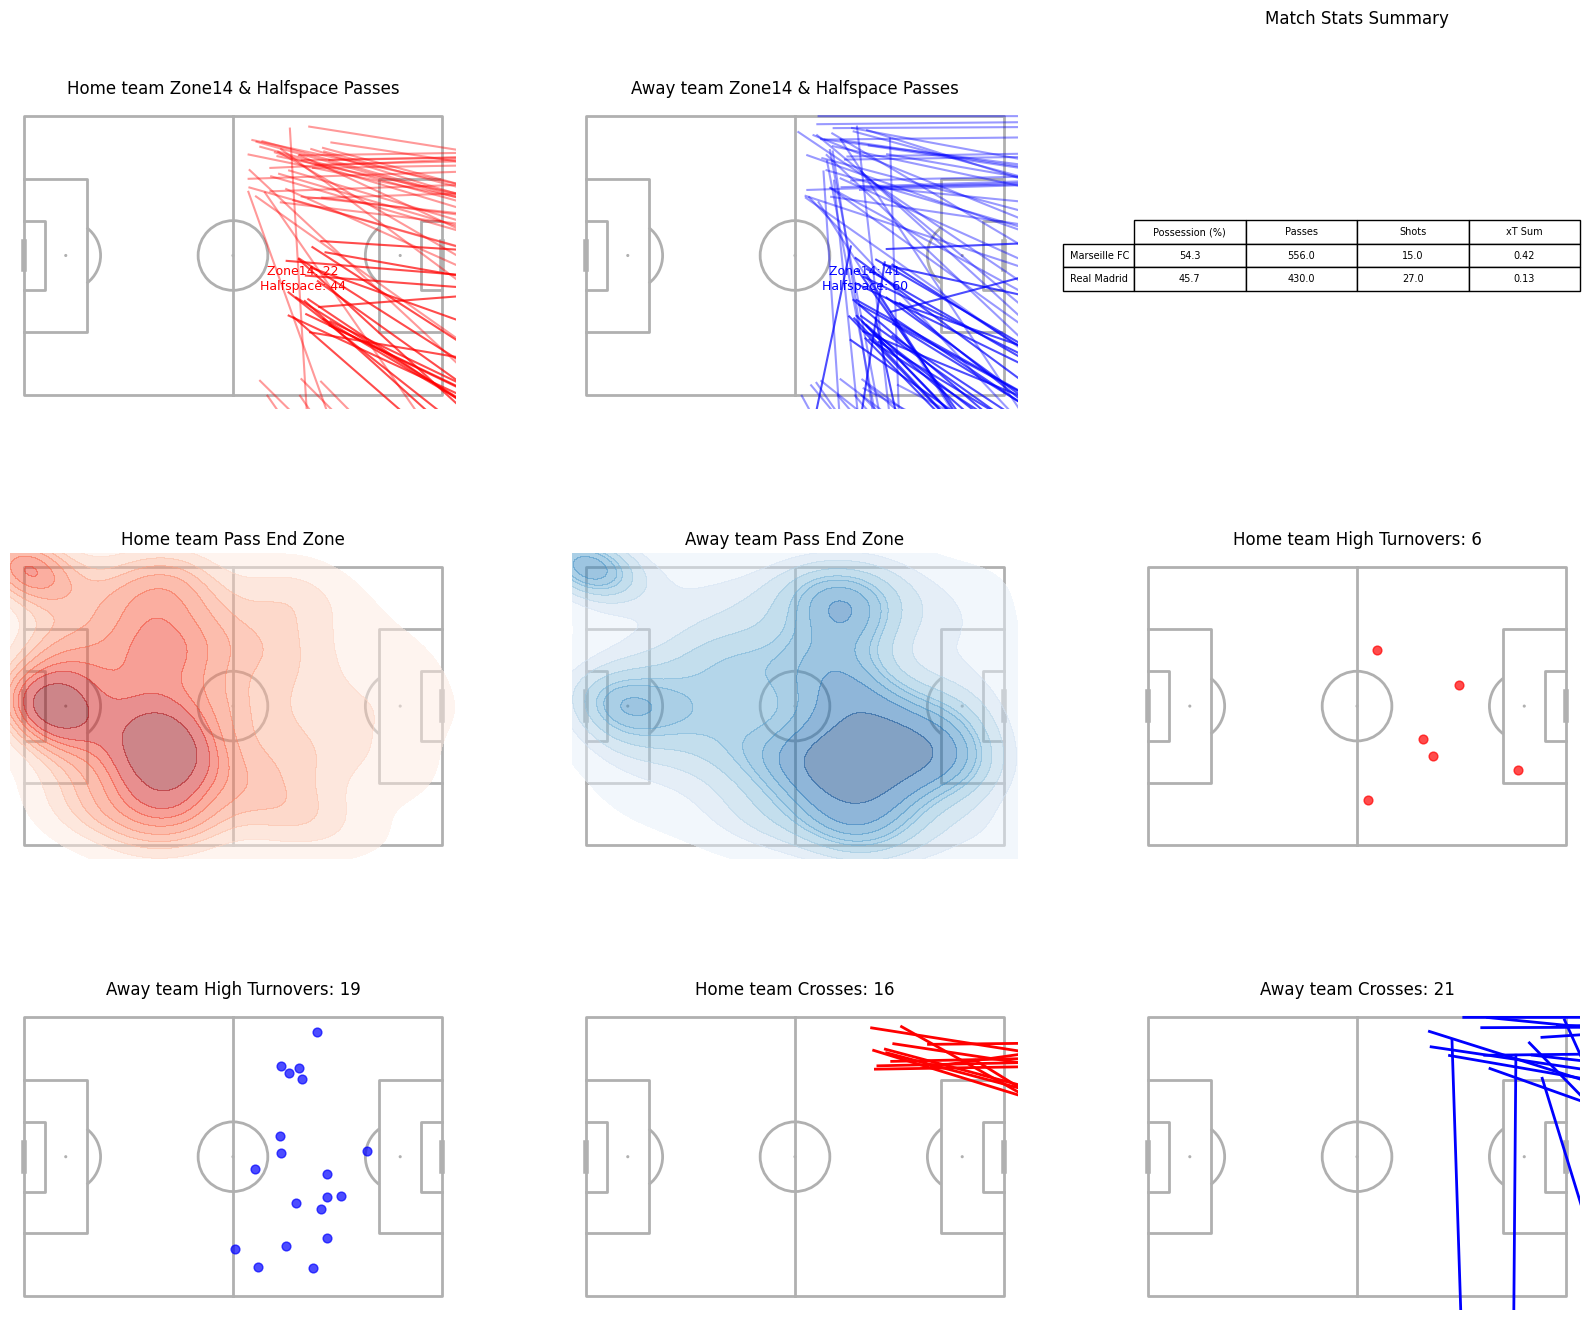

In [ ]:

team_map = {
    "27xvwccz8kpmqsefjv2b2sc0o": "Marseille FC",
    "3kq9cckrnlogidldtdie2fkbl": "Real Madrid"
}
df['teamName'] = df['team_name'].map(team_map)

home_df = df[df['teamName'] == 'Marseille FC']
away_df = df[df['teamName'] == 'Real Madrid']


fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()
pitch = Pitch(pitch_type='statsbomb')


def zone14_halfspace_passes(df, color, ax, title):
    pitch.draw(ax=ax)
    zone14 = df[(df['typeId'] == 'Pass') & (df['x'].between(75, 90)) & (df['y'].between(35, 65))]
    halfspace = df[(df['typeId'] == 'Pass') & (df['x'].between(60, 90)) & ((df['y'].between(0, 25)) | (df['y'].between(75, 100)))]
    pitch.lines(zone14.x, zone14.y, zone14.x2_bin_xT*100, zone14.y2_bin_xT*100, lw=1.5, color=color, alpha=0.7, ax=ax)
    pitch.lines(halfspace.x, halfspace.y, halfspace.x2_bin_xT*100, halfspace.y2_bin_xT*100, lw=1.5, color=color, alpha=0.4, ax=ax)
    ax.set_title(title, fontsize=12)
    ax.text(80, 50, f"Zone14: {len(zone14)}\nHalfspace: {len(halfspace)}", fontsize=9, ha='center', color=color)

zone14_halfspace_passes(home_df, 'red', axes[0], "Home team Zone14 & Halfspace Passes")
zone14_halfspace_passes(away_df, 'blue', axes[1], "Away team Zone14 & Halfspace Passes")


match_stats = {
    'Possession (%)': [round(len(home_df)/len(df)*100,1), round(len(away_df)/len(df)*100,1)],
    'Passes': [len(home_df[home_df['typeId']=='Pass']), len(away_df[away_df['typeId']=='Pass'])],
    'Shots': [len(home_df[home_df['typeId'].isin(['Goal','Miss','Attempt Saved'])]),
              len(away_df[away_df['typeId'].isin(['Goal','Miss','Attempt Saved'])])],
    'xT Sum': [round(home_df['xT'].sum(),2), round(away_df['xT'].sum(),2)]
}
stats_df = pd.DataFrame(match_stats, index=['Marseille FC', 'Real Madrid'])
axes[2].axis('off')
axes[2].table(cellText=stats_df.values, colLabels=stats_df.columns, rowLabels=stats_df.index,
              cellLoc='center', loc='center')
axes[2].set_title("Match Stats Summary", fontsize=12)


pitch.draw(ax=axes[3])
sns.kdeplot(x=home_df.x, y=home_df.y, fill=True, cmap='Reds', ax=axes[3], alpha=0.5)
axes[3].set_title("Home team Pass End Zone", fontsize=12)

pitch.draw(ax=axes[4])
sns.kdeplot(x=away_df.x, y=away_df.y, fill=True, cmap='Blues', ax=axes[4], alpha=0.5)
axes[4].set_title("Away team Pass End Zone", fontsize=12)


def get_turnovers(df):
    return df[(df['typeId'].isin(['Tackle','Interception','Dispossessed'])) & (df['x'] > 60)]

home_turn = get_turnovers(home_df)
away_turn = get_turnovers(away_df)

pitch.draw(ax=axes[5])
pitch.scatter(home_turn.x, home_turn.y, s=40, color='red', alpha=0.7, ax=axes[5])
axes[5].set_title(f"Home team High Turnovers: {len(home_turn)}", fontsize=12)

pitch.draw(ax=axes[6])
pitch.scatter(away_turn.x, away_turn.y, s=40, color='blue', alpha=0.7, ax=axes[6])
axes[6].set_title(f"Away team High Turnovers: {len(away_turn)}", fontsize=12)


def get_crosses(df):
    return df[(df['typeId'] == 'Pass') & (df['x'] > 80) & ((df['y'] < 20) | (df['y'] > 80))]

home_cross = get_crosses(home_df)
away_cross = get_crosses(away_df)

pitch.draw(ax=axes[7])
pitch.lines(home_cross.x, home_cross.y, home_cross.x2_bin_xT*100, home_cross.y2_bin_xT*100, color='red', lw=2, ax=axes[7])
axes[7].set_title(f"Home team Crosses: {len(home_cross)}", fontsize=12)

pitch.draw(ax=axes[8])
pitch.lines(away_cross.x, away_cross.y, away_cross.x2_bin_xT*100, away_cross.y2_bin_xT*100, color='blue', lw=2, ax=axes[8])
axes[8].set_title(f"Away team Crosses: {len(away_cross)}", fontsize=12)

plt.tight_layout()
plt.show()
